<a href="https://colab.research.google.com/github/MoAbbasid/100_Days_of_ML/blob/main/Huggingface%20Agents/FirstLlamaIndexAgent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install llama-index llama-index-llms-huggingface transformers

In [ ]:
# First, let's make sure we have the necessary libraries installed.
# We've added llama-index-llms-huggingface-api for the new model.
!pip install llama-index llama-index-llms-huggingface-api pyvis -U -q

In [ ]:
!pip install httpx

In [ ]:
!pip install llama-index llama-index-llms-groq pyvis -U -q
from google.colab import userdata

In [ ]:
# -*- coding: utf-8 -*-
"""
Dynamic Storyteller Agent using LlamaIndex Workflows
"""
from llama_index.llms.groq import Groq
from huggingface_hub import login
import textwrap
from llama_index.core.workflow import (
    Workflow,
    step,
    StartEvent,
    StopEvent,
    Context,
    Event,
)
from llama_index.llms.huggingface_api import HuggingFaceInferenceAPI

# --- Event Definitions ---
# These classes define the data that flows between our steps.

class StoryContext(Event):
    """Event to hold the current state of our story and inventory."""
    story_part: str
    inventory: list[str]

class UserChoice(Event):
    """Event to hold the user's selected choice."""
    choice: str

class StoryEnd(Event):
    """Event to signal the end of the story."""
    final_message: str

class SceneReadyEvent(Event):
    """Fired after the story text and image have been fully displayed."""
    pass
# # --- Log in to Hugging Face ---
# # This will prompt you to enter your Hugging Face API token.
# print("Please log in to Hugging Face...")
# login()
# print("Login successful!")

# --- Set up our AI model ---
api_key = "YOUR_GROQ_API_KEY"

# We're using Llama 3 on Groq. The model name is specific to their platform.
llm = Groq(model="llama3-8b-8192", api_key=userdata.get('GROQ_TOKEN'))

TimeoutException: Requesting secret GROQ_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.

In [ ]:
import textwrap
import requests
from PIL import Image
from io import BytesIO
from IPython.display import display, Image as IPImage
import httpx
import asyncio
# --- Image Generation ---

async def generate_and_display_image(prompt: str, hf_token: str):
    """
    Asynchronously generates an image.
    This version has a longer timeout and handles timeout errors gracefully.
    """
    API_URL = "https://api-inference.huggingface.co/models/stabilityai/stable-diffusion-xl-base-1.0"
    headers = {"Authorization": f"Bearer {hf_token}"}
    full_prompt = f"epic fantasy art, digital painting, cinematic lighting, {prompt}"
    payload = {"inputs": full_prompt}

    print("\n[+] Generating scene image in the background...")

    try:
        # Use an async client with a longer timeout (3 minutes)
        async with httpx.AsyncClient() as client:

            response = await client.post(API_URL, headers=headers, json=payload, timeout=180.0) # Increased timeout to 3 minutes

        response.raise_for_status() # This will raise an error for bad responses (like 4xx or 5xx)

        image_bytes = response.content
        print("[+] Image loaded successfully!")
        display(IPImage(data=image_bytes, width=600))

    # --- THIS IS THE OTHER KEY CHANGE ---
    except httpx.TimeoutException:
        # Catch the specific timeout error and handle it gracefully
        print("--> The image generator is very busy and took too long to respond. Continuing without an image for this scene.")
    except Exception as e:
        # Catch any other potential errors
        print(f"--> (Background) An error occurred during image generation: {e}")

# --- Step 3: The Main Workflow Class ---
class StorytellerWorkflow(Workflow):
    # Set a longer timeout because model inference can be slow
    def __init__(self, **kwargs):
        super().__init__(timeout=120, **kwargs)

    @step
    async def generate_story_part(self, ev: StartEvent | UserChoice, ctx: Context) -> StoryContext | StoryEnd:
        inventory = await ctx.store.get("inventory", [])
        prompt = ""

        if isinstance(ev, StartEvent):
            prompt = """
            You are a creative text adventure game master. Your output is for a console game.
            Start a new story about a curious explorer entering a recently discovered, glowing cave.
            Keep the tone mysterious and exciting.
            After the story part, provide two distinct choices for the player to make.

            Format your response exactly like this:
            STORY:
            [The story text goes here]
            CHOICES:
            1. [First choice]
            2. [Second choice]
            """
        elif isinstance(ev, UserChoice):
            last_story_part = await ctx.store.get("last_story_part")
            prompt = f"""
            You are a creative text adventure game master. Your output is for a console game.
            The story so far: "{last_story_part}"
            The player chose: "{ev.choice}"
            The player's inventory: {inventory}

            Continue the story. If a choice logically results in the player acquiring an item, add it to their inventory by including the tag `[ADD_ITEM: item name]` anywhere in the story text.
            If the story should end, write "[END]" on the very first line.
            Otherwise, create a new part of the story and provide two new distinct choices.

            Format your response exactly like this:
            STORY:
            [The story text goes here]
            CHOICES:
            1. [First choice]
            2. [Second choice]
            """

        response = await llm.acomplete(prompt)
        response_text = str(response)

        # --- NEW INVENTORY LOGIC STARTS HERE ---
        import re
        items_found = re.findall(r"\[ADD_ITEM: (.*?)\]", response_text)
        if items_found:
            for item in items_found:
                if item not in inventory:
                    inventory.append(item)
            # Remove the tag from the text the user sees
            response_text = re.sub(r"\[ADD_ITEM: (.*?)\]", "", response_text).strip()
        # --- NEW INVENTORY LOGIC ENDS HERE ---

        if response_text.strip().startswith("[END]"):
            final_message = response_text.strip().replace("[END]", "")
            return StoryEnd(final_message=f"\n--- THE END ---\n{final_message}")

        try:
            story_section = response_text.split("STORY:")[1].split("CHOICES:")[0].strip()
            choices_section = response_text.split("CHOICES:")[1].strip()
            full_story_part = f"{story_section}\n\nChoices:\n{choices_section}"
        except IndexError:
            full_story_part = "The story continues... but the path ahead is blurry. Let's try to find our way again from here."

        await ctx.store.set("last_story_part", full_story_part)
        await ctx.store.set("inventory", inventory)

        return StoryContext(story_part=full_story_part, inventory=inventory)

    @step
    async def display_scene(self, ev: StoryContext) -> SceneReadyEvent:
        """
        Step 1 of player interaction: Display the story text, then wait for
        the image to generate and display. Only then, move on.
        """
        story_text = ev.story_part
        narrative = story_text
        choices_section = ""

        if "\nChoices:\n" in story_text:
            parts = story_text.split("\nChoices:\n", 1)
            narrative = parts[0]
            choices_section = "Choices:\n" + parts[1]

        # Display the text part of the scene first
        wrapped_narrative = textwrap.fill(narrative, width=80)
        print("\n" + "="*50 + "\n")
        print(wrapped_narrative)
        if choices_section:
            print("\n" + choices_section)
        print("\n" + "="*50 + "\n")

        # Now, generate and AWAIT the image. The user sees the text while this happens.
        from huggingface_hub import HfFolder
        hf_token = HfFolder.get_token()
        if hf_token:
             # We 'await' here, deliberately pausing until the image is ready.
             await generate_and_display_image(narrative, hf_token)

        # Signal that the full scene is ready for input.
        return SceneReadyEvent()

    @step
    async def get_user_choice(self, ev: SceneReadyEvent) -> UserChoice | StopEvent:
        """
        Step 2 of player interaction: Now that the scene is displayed,
        get the user's input without any background tasks running.
        """
        prompt_message = "What do you do? (Type your choice and press Enter) > "

        # Since no background tasks are running, we can use simple input.
        # However, run_in_executor is still best practice for non-blocking UIs.
        loop = asyncio.get_running_loop()
        choice_text = await loop.run_in_executor(None, input, prompt_message)

        if choice_text.lower() in ["quit", "exit"]:
            print("Exiting game.")
            return StopEvent(result="Game exited by user.")

        return UserChoice(choice=choice_text)

    @step
    def end_story(self, ev: StoryEnd) -> StopEvent:
        # Also wrap the final message
        wrapped_final_message = textwrap.fill(ev.final_message, width=80)
        print(wrapped_final_message)
        return StopEvent(result="Story finished.")

Starting the Dynamic Storyteller...


You've spent years searching for the lost cave, pouring over dusty maps and
scouring the wilderness for any sign of its existence. And finally, after months
of trekking through the dense forest, you've stumbled upon it. The entrance to
the cave is a yawning mouth of darkness, but as you approach, you notice
something strange. The air around the cave seems to be... glowing. A soft,
ethereal light emanates from within, casting an otherworldly glow over the
surrounding trees.  As you step inside, the air grows thick with an eerie,
pulsating energy. You can feel it vibrating through your very being, making your
skin tingle and your heart race. The walls of the cave are slick with moisture,
and the sound of dripping water echoes through the darkness. But it's not just
the sound of water that you hear - there's something else, a low hum, like the
distant thrumming of a bass note.  You fumble for your flashlight, but as you
turn it on, you realize that it

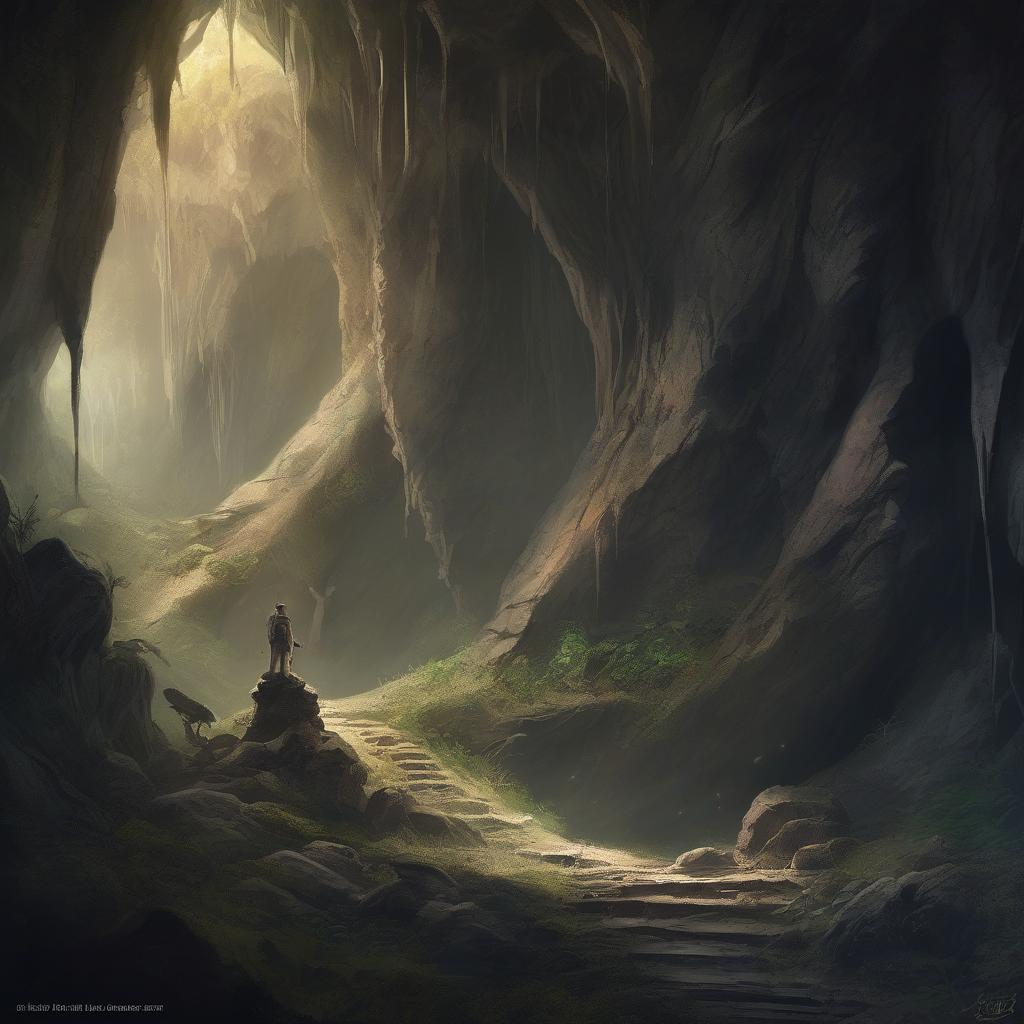

What do you do? (Type your choice and press Enter) > 1


As you examine the symbols more closely, you notice that they seem to be some
sort of ancient language, etched into the walls of the cave with a precision
that's almost... otherworldly. You can feel the energy emanating from them, and
you begin to sense that they might be more than just simple decorations. You
wonder if they might hold some kind of secret or message, and you decide to try
and decipher their meaning.  As you study the symbols, you notice that one of
them seems to be slightly different from the others. It's a small, intricate
design that appears to be some sort of key or lock. You wonder if it might be a
clue to unlocking the secrets of the cave, and you reach out to touch it.  As
soon as your skin makes contact with the symbol, you feel a sudden surge of
energy course through your body. The air around you seems to shimmer and
distort, and you feel yourself being pulled towards the symbol. You try to step
back, but

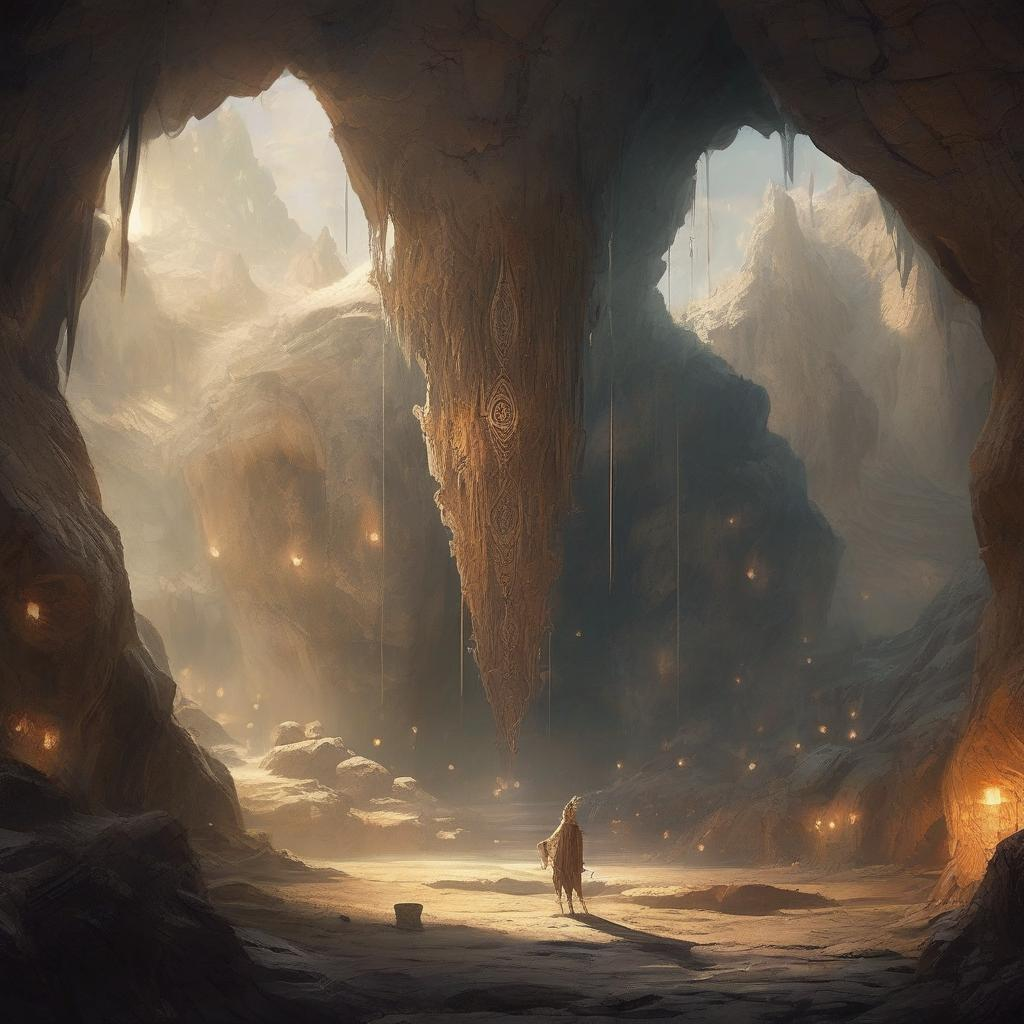

What do you do? (Type your choice and press Enter) > 1


As you examine the orbs, you notice that they're emitting a soft, pulsing glow.
The light is mesmerizing, and you find yourself drawn to the orbs, feeling an
inexplicable connection to them. You reach out a hand to touch one, and as soon
as your skin makes contact, you're flooded with visions and images. You see
ancient civilizations, long-lost technologies, and mysterious rituals. The
visions are fragmented and unclear, but you sense that they're trying to convey
a message.  As the visions fade, you notice that one of the orbs has changed
color, shifting from a soft blue to a vibrant orange. You feel a strange energy
emanating from it, and you sense that it might be trying to communicate with
you. You wonder if this orb might be the key to unlocking the secrets of the
cave.

Choices:
1. Try to communicate with the orange orb, hoping to glean more information about the cave and its secrets.
2. Search the chamber for any physical 

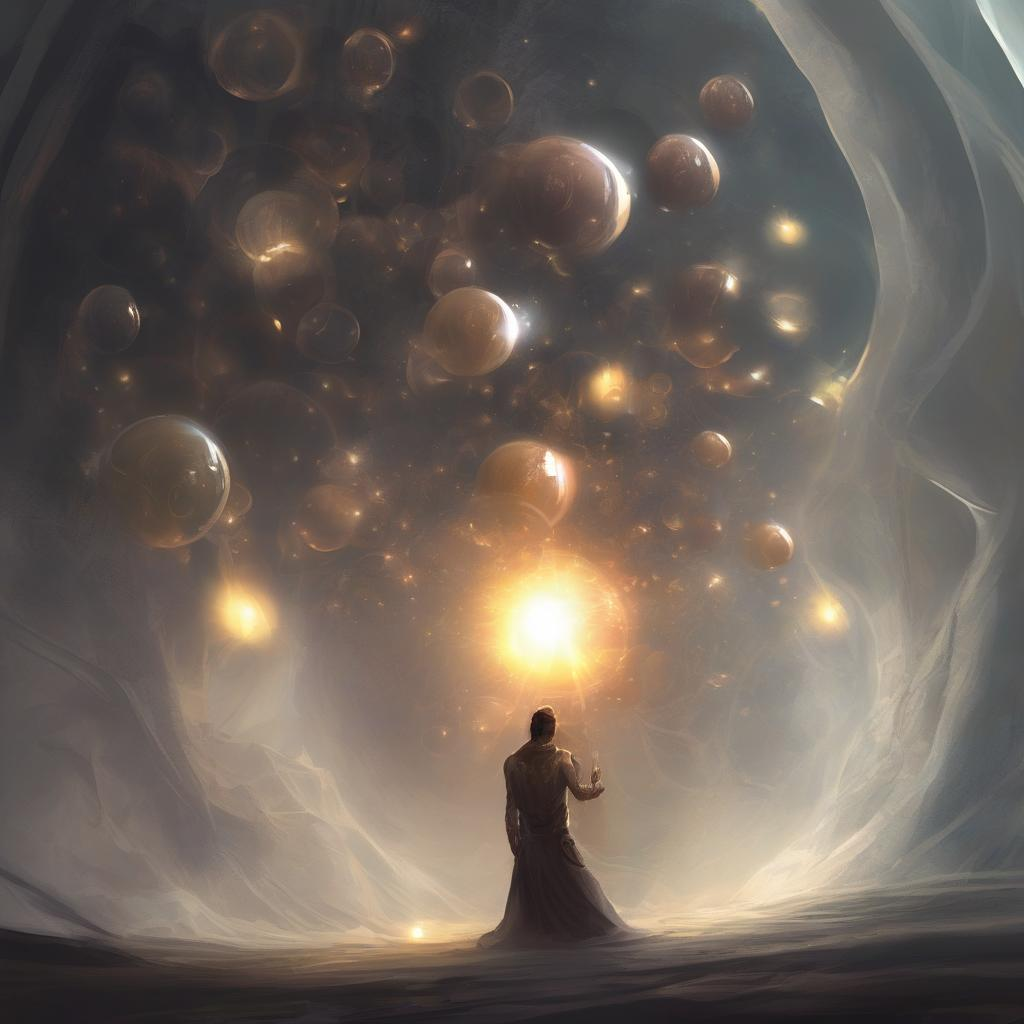

ERROR:asyncio:Exception in callback Dispatcher.span.<locals>.wrapper.<locals>.handle_future_result(span_id='Workflow.run...-4a942701dce3', bound_args=<BoundArguments ()>, instance=<__main__.Sto...x7d9e60b3ab90>, context=<_contextvars...x7d9d41da7f00>)(<WorkflowHand...120 seconds')>) at /usr/local/lib/python3.11/dist-packages/llama_index_instrumentation/dispatcher.py:277
handle: <Handle Dispatcher.span.<locals>.wrapper.<locals>.handle_future_result(span_id='Workflow.run...-4a942701dce3', bound_args=<BoundArguments ()>, instance=<__main__.Sto...x7d9e60b3ab90>, context=<_contextvars...x7d9d41da7f00>)(<WorkflowHand...120 seconds')>) at /usr/local/lib/python3.11/dist-packages/llama_index_instrumentation/dispatcher.py:277>
Traceback (most recent call last):
  File "/usr/lib/python3.11/asyncio/events.py", line 84, in _run
    self._context.run(self._callback, *self._args)
  File "/usr/local/lib/python3.11/dist-packages/llama_index_instrumentation/dispatcher.py", line 290, in handle_future_res

WorkflowTimeoutError: Operation timed out after 120 seconds

What do you do? (Type your choice and press Enter) > quit


In [ ]:
# --- Run the Workflow! ---
async def main():
    print("Starting the Dynamic Storyteller...")
    workflow = StorytellerWorkflow()
    result = await workflow.run()
    print("\nWorkflow finished with result:", result)

await main()